# HOMEWORK 5

In this homework you are going to implement the **Floyd-Steinberg dithering** algorithm. Dithering, in general, means that we are adding noise to the signal (in our case digital image) in order to perceive it better. In other words, by adding the noise the objective quality will be worse but the subjective quality will be better (i.e. the image will "look" better).

The details of FS dithering can be found in this [wiki](https://en.wikipedia.org/wiki/Floyd%E2%80%93Steinberg_dithering) page. In order to implement the dithering, we will implement the following steps:
* Define colour pallette
* Quantize the image to obtain the baseline and compute the average quantization error
* Implement FS dithering and compute the average quantization error

You will also have to answer the question at the end of this notebook.

Note: In this homework, you will have the chance to earn some extra points. See the "Bonus" section at the end of the notebook. Good luck!

As always, you are encouraged to use your own images :-)

In [1]:
import cv2
import math
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

Let's load the image.

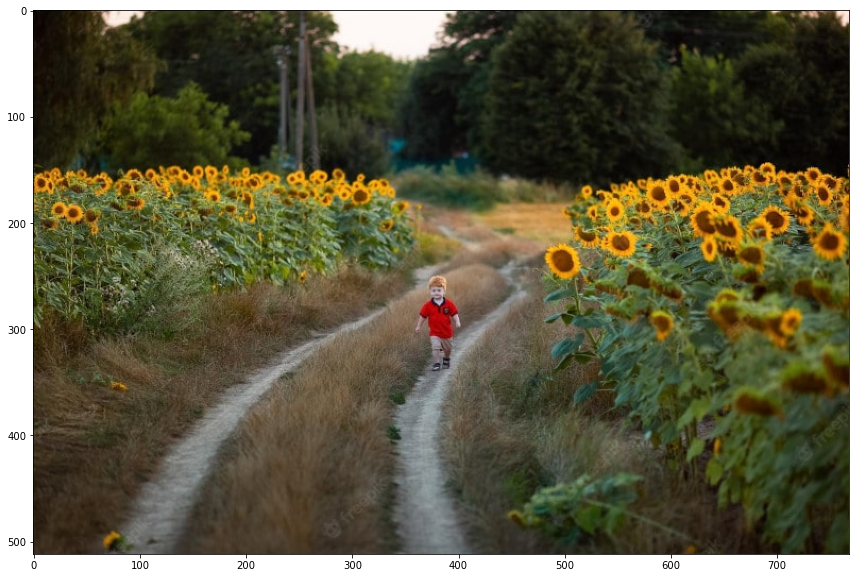

In [2]:
# Load image
img = cv2.imread('./data/blade_runner-min.jpg')
# Convert it to RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# Plot it
plt.imshow(img)

Let's start with gray tones first.

In [3]:
# Black, dark gray, light gray, white
colors = np.array([[0, 0, 0],
                   [64, 64, 64],
                   [192, 192, 192],
                   [255, 255, 255]])

Using the colour pallette, let's quantize the original image.

In [4]:
# Cast the image to float
img = img.astype(np.float32) / 255

In [5]:
# Prepare for quantization
rows, cols, channels = img.shape
quantized = np.zeros_like(img)

def getColorEuclideanDistance(col1, col2):
    return math.sqrt((col1[0] - col2[0])**2 + (col1[1] - col2[1])**2 + (col1[2] - col2[2])**2)

def findClosestColorByPalette(color, pallete):
    color = color * 255
    distances = np.array([])
    for pColor in pallete:
        distances = np.append(distances, getColorEuclideanDistance(color, pColor))
    return pallete[np.argmin(distances)] / 255      

from tqdm import tqdm

# Apply quantization
for r in tqdm(range(rows)):
    for c in range(cols):
        # Extract the original pixel value
        pixel = img[r, c]
        
        # Find the closest colour from the pallette (using absolute value/Euclidean distance)
        # Note: You may need more than one line of code here
        new_pixel = findClosestColorByPalette(pixel, colors)
        
        # Apply quantization
        quantized[r, c, :] = new_pixel

100%|██████████| 512/512 [00:24<00:00, 20.91it/s]


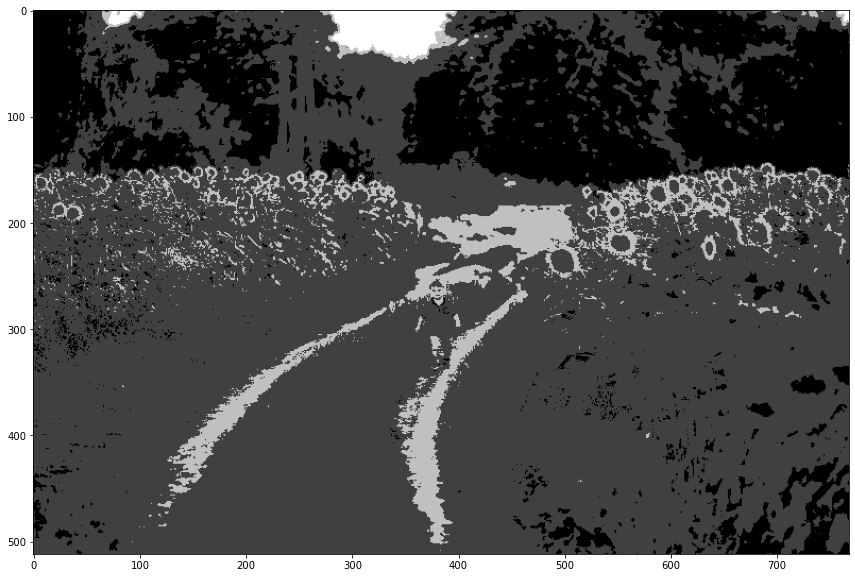

In [6]:
# Show quantized image (don't forget to cast back to uint8)
quantized = (quantized * 255).astype(np.uint8)
plt.imshow(quantized)

In [7]:
# Compute average quantization error
def psnr(ref, target):
    error = ref.astype(np.float32) - target.astype(np.float32)
    mse = np.mean(error**2)
    return 10 * np.log10((255**2)/mse)

avg_quant_error = psnr(img, quantized)

print('avg_quant_error', avg_quant_error)

avg_quant_error 10.277491005526047


#### Floyd-Steinberg Dithering
We are now going to implement the FS dithering and compare it to the optimally quantized image we have calculated above.

In [8]:
# Make a temporal copy of the original image, we will need it for error diffusion
img_tmp = np.copy(img)
dithering = np.zeros_like(img)

def doDithering():
    for r in tqdm(range(1, rows-1)):
        for c in range(1, cols-1):
            # Extract the original pixel value
            pixel = img_tmp[r][c]

            # Find the closest colour from the pallette (using absolute value/Euclidean distance)
            # Note: You may need more than one line of code here
            new_pixel = findClosestColorByPalette(pixel, colors)

            # Compute quantization error
            quant_error = pixel - new_pixel

            # Diffuse the quantization error accroding to the FS diffusion matrix
            # Note: You may need more than one line of code here
            img_tmp[r, c] = new_pixel
            img_tmp[r][c + 1]     = img_tmp[r][c + 1]     + ((7/16) * quant_error)
            img_tmp[r + 1][c - 1] = img_tmp[r + 1][c - 1] + ((3/16) * quant_error)
            img_tmp[r + 1][c]     = img_tmp[r + 1][c]     + ((5/16) * quant_error)
            img_tmp[r + 1][c + 1] = img_tmp[r + 1][c + 1] + ((1/16) * quant_error)

            # Apply dithering
            dithering[r, c, :] = new_pixel
            
doDithering()

100%|██████████| 510/510 [00:28<00:00, 17.88it/s]


(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x2b742da6070>)

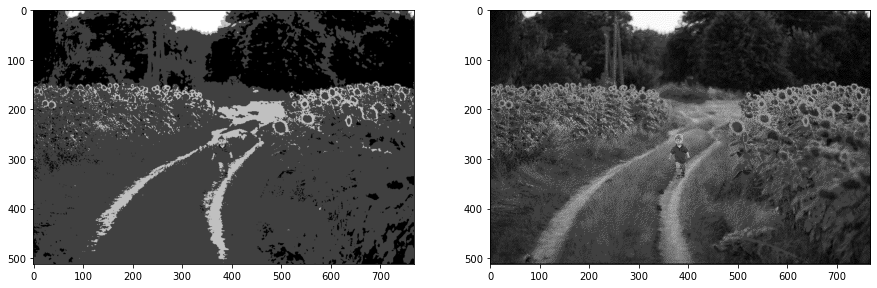

In [9]:
# Show quantized image (don't forget to cast back to uint8)
dithering = (dithering * 255).astype(np.uint8)
plt.subplot(121), plt.imshow(quantized)   # optimally quantized
plt.subplot(122), plt.imshow(dithering)   # dithering

In [10]:
# Compute average quantization error for dithered image
avg_dith_error = psnr(img, dithering)
print('avg_dith_error', avg_dith_error)

avg_dith_error 9.481150126016935


### Questions
* Which image has higher quantization error? Optimally quantized or dithered?

`It looks like the quantized image has a higher value than dithered`

* Which image looks better to you?

`The dithered one of course. It reminds just an original image with the light noise filter`

* Can you repeat the same process using only two colours: black and white? Show me :-)

`Sure, there are 2 methods:`

1. The first method is just reducing of the palette from gray gradient to black and white:

100%|██████████| 510/510 [00:18<00:00, 27.96it/s]


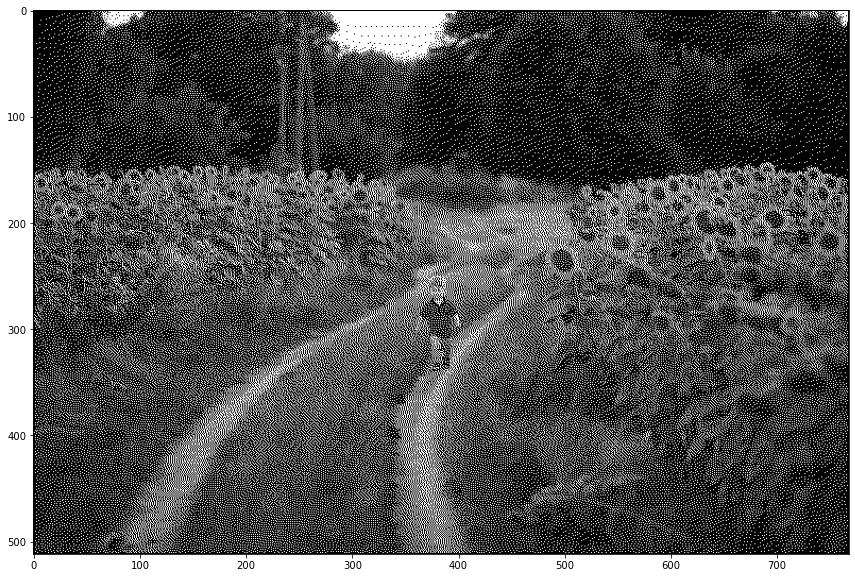

In [11]:
colors = np.array([[0, 0, 0], [255, 255, 255]])
img_tmp = np.copy(img)
dithering = np.zeros_like(img)

doDithering()
dithering = (dithering * 255).astype(np.uint8)
plt.imshow(dithering)

2. The second method (a little bit faster) is checking the threshold of the mean color pixel. If it is > 0.5, then it is white, else it is black

100%|██████████| 510/510 [00:10<00:00, 46.50it/s]


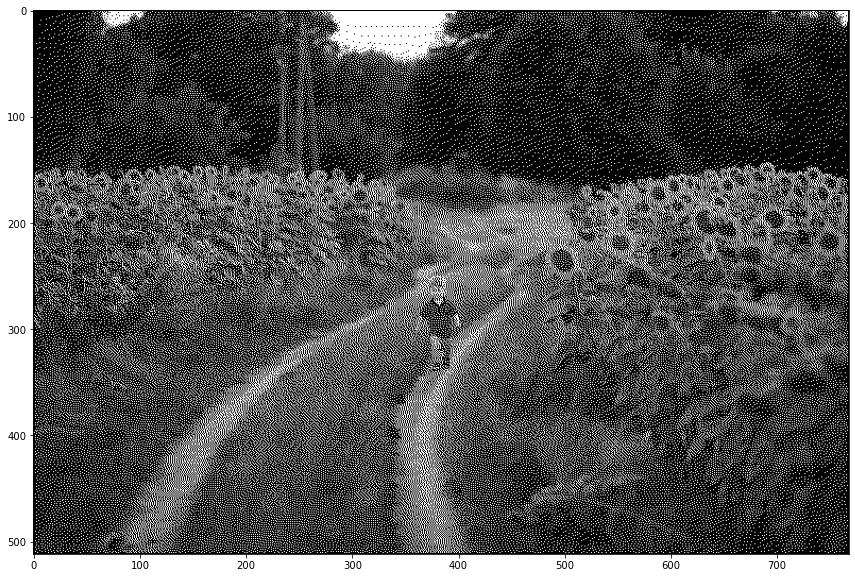

In [12]:
# Make a temporal copy of the original image, we will need it for error diffusion
img_tmp = np.copy(img)
dithering = np.zeros_like(img)

for r in tqdm(range(1, rows-1)):
    for c in range(1, cols-1):
        # Extract the original pixel value
        pixel = img_tmp[r][c]

        # Find the closest colour from the pallette (using absolute value/Euclidean distance)
        # Note: You may need more than one line of code here
        if np.average(pixel) > 0.5:
            new_pixel = [1, 1, 1]
        else:
            new_pixel = [0, 0, 0]

        # Compute quantization error
        quant_error = pixel - new_pixel

        # Diffuse the quantization error accroding to the FS diffusion matrix
        # Note: You may need more than one line of code here
        img_tmp[r, c] = new_pixel
        img_tmp[r][c + 1]     = img_tmp[r][c + 1]     + ((7/16) * quant_error)
        img_tmp[r + 1][c - 1] = img_tmp[r + 1][c - 1] + ((3/16) * quant_error)
        img_tmp[r + 1][c]     = img_tmp[r + 1][c]     + ((5/16) * quant_error)
        img_tmp[r + 1][c + 1] = img_tmp[r + 1][c + 1] + ((1/16) * quant_error)

        # Apply dithering
        dithering[r, c, :] = new_pixel

dithering = (dithering * 255).astype(np.uint8)
plt.imshow(dithering)

### Bonus Points

Repeat the homework using a diffrerent image pallette. For instance, you can use an optimal colour
pallette that we can calculate via k-means algorithm. The following snippet of code will give you the 16
optimal colours for your original image.

100%|██████████| 510/510 [01:24<00:00,  6.01it/s]


(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x2b747728130>)

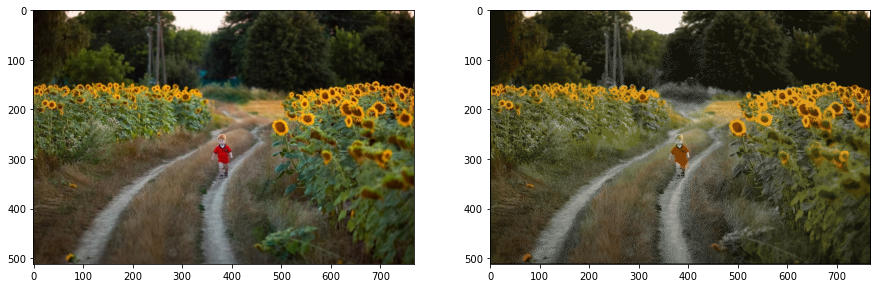

In [15]:
# Load image
img = cv2.imread('./data/blade_runner-min.jpg')
# Convert it to RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=16).fit(img.reshape((img.shape[0] * img.shape[1], 3)))
colors = kmeans.cluster_centers_

# Cast the image to float
img = img.astype(np.float32) / 255

img_tmp = np.copy(img)
dithering = np.zeros_like(img)

doDithering()
dithering = (dithering * 255).astype(np.uint8)
plt.subplot(121), plt.imshow(img)   # origianl
plt.subplot(122), plt.imshow(dithering)   # dithering

100%|██████████| 510/510 [02:37<00:00,  3.24it/s]


(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x2b74bd76a00>)

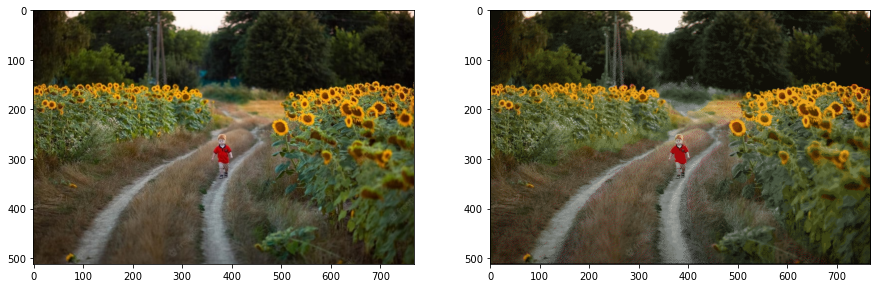

In [19]:
# Load image
img = cv2.imread('./data/blade_runner-min.jpg')
# Convert it to RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

kmeans = KMeans(n_clusters=32).fit(img.reshape((img.shape[0] * img.shape[1], 3)))
colors = kmeans.cluster_centers_

# Cast the image to float
img = img.astype(np.float32) / 255

img_tmp = np.copy(img)
dithering = np.zeros_like(img)

doDithering()
dithering = (dithering * 255).astype(np.uint8)
plt.subplot(121), plt.imshow(img)   # origianl
plt.subplot(122), plt.imshow(dithering)   # dithering

100%|██████████| 510/510 [19:58<00:00,  2.35s/it]


(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x2b747460370>)

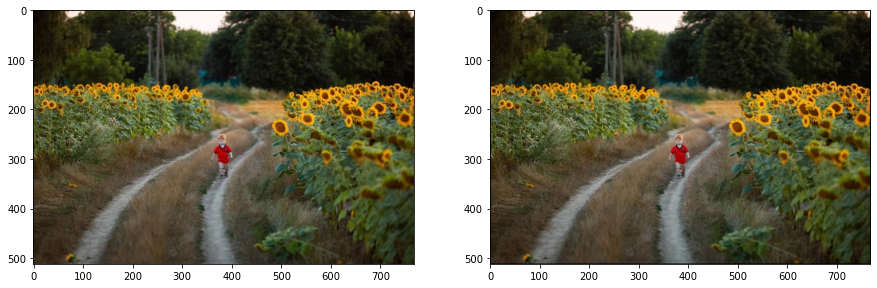

In [18]:
# Load image
img = cv2.imread('./data/blade_runner-min.jpg')
# Convert it to RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

kmeans = KMeans(n_clusters=256).fit(img.reshape((img.shape[0] * img.shape[1], 3)))
colors = kmeans.cluster_centers_

# Cast the image to float
img = img.astype(np.float32) / 255

img_tmp = np.copy(img)
dithering = np.zeros_like(img)

doDithering()
dithering = (dithering * 255).astype(np.uint8)
plt.subplot(121), plt.imshow(img)   # origianl
plt.subplot(122), plt.imshow(dithering)   # dithering

Apply FS dithering the same way you did before.
* How does the result look like to you?

`Reds and greens pixels are not saturated enough and there are some noise, but this picture already has colors :)`

* What happens if we use 32 colours?

`Pixels have right saturation and hue - picture look good! But it takes too much time - 3-4 min`

* And what happens if we use 256 colours?

`Pretty good, the picture looks like original. But it takes about 25+ min`